<img src="./img/HWNI_logo.svg"/>

# Lab 08 - Visualizing Models

In [1]:
%matplotlib notebook

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

import pandas as pd

# choose colors that work for most color-blind folks
sns.set_palette("colorblind")
sns.set(color_codes=True)

import util.lab08utils as utils

from ipywidgets import interact,interactive, fixed, interact_manual

utils.formatDataframes()

# Introduction

When we model the relationship between two observed variables, we need the following ingredients:

- a function, which we'll call the *modeling function*, that takes one of the variables as its input and produces a guess for what the other variable is as its output
- a "noise term" that specifies what we expect our errors to look like

Let's write these mathematically. We'll denote our input variable as $x$ and the variable we are trying to predict as $y$ (because [that's what Descartes did in 1637](http://math.stackexchange.com/questions/2936/why-are-x-and-y-such-common-variables-in-todays-equations-how-did-their-use-or/)). We'll call the guess generated by our model $\hat{y}$. We will auspiciously call our errors $\epsilon$ (pronounced "epp-sih-lawn"), since we hope for them to be small, and $\epsilon$ is the traditional symbol for "very small, but not 0". Our errors are random (or else we'd try to predict them!) and so they have a probability distribution, $p(\epsilon)$. When we want to say some random number is distributed according to some distribution, we write $x \sim p(x)$.

Putting all of that together, here's how we write down the problem of modeling the relationship between two variables, $x$ and $y$:


$$
\hat{y} = f(x) \\
\epsilon \sim p(\epsilon)\\
y = \hat{y} + \epsilon
$$

In almost all of the models below, we will assume that $p(\epsilon)$ is a normal distribution with a mean of $0$ and some standard deviation $\sigma$. The normal distribution comes up frequently enough that there is a special symbol for it. The most common version is a fancy (aka "script") N: $\mathcal{N}(\mu,\sigma)$ for a normal distribution with mean $\mu$ and variance $\sigma$. Combining our assumption with our new notation, we can rewrite our equations:


$$
\hat{y} = f(x) \\
\epsilon \sim \mathcal{N}(0,\sigma)\\
y = \hat{y} + \epsilon
$$

Some things to note: since $\epsilon$ is random, $y$ is random. That means that our model specifies a distribution for $y$, and we know exactly what it is. Below, we'll visualize this distribution. Also, notice that, once we pick a distribution for our errors, changing $f$ is the only way we can change our model. Below, we'll also visualize some common choices for $f$.

## Linear Models

Linear models are the simplest class of models. The assumption of linearity is both strong -- it greatly reduces the things we can potentially model -- and powerful -- as we'll see next week, it makes modeling much easier!

### Specifying Linear Models

In a linear model, $f$ is a linear function. If $x$ is a number, that means $f$ is just a number to multiply $x$ by. If $x$ is a vector, that means $f$ is a vector that we multiply $x$ by -- remember that, in the case of vectors, "multiply" means "compute the dot product between".

The dot product is also sometimes called the *weighted sum*. Because of this, we call the $f$ vector the "weight vector", alias $w$.

Putting this together, we can specify the linear model as

$$
y =  w \cdot x + \epsilon
$$

The dot product can be written in many ways. Below, we'll find it useful to write it as

$$
y = w^T x + \epsilon
$$

where $w^T$ means "$w$-transposed", or flipped on its side.

This is slightly different from the way that the lecture notes write down the linear model, but in my opinion, it makes the math easier to follow.

The only differences are in the order things are written down and the shapes of the various arrays. Remember that, unlike in regular multiplication, when we're doing matrix-vector multiplication, we need to keep a close eye on the shapes of our matrices and vectors. 

#### Tracking Array Shapes

For a matrix that has $r$ rows and $c$ columns, the shape is written as $(r, c)$. We can only add matrices or vectors that are the same shape. We can only multiply two matrices or vectors when the number of *columns* in the first matches the number of *rows* in the second. The resulting matrix or vector has the same number of *rows* as the first and the same number of *columns* as the second. This sounds complicated, but it's actually not! We can write down a "shape equation" that's analogous to the "unit equations" used in physics and chemistry:

$$
(A,B)\cdot(B,C) = (A,C) \\
(A,B) + (A,B) = (A,B)
$$

Before writing down code that involves matrices and vectors, it's useful to sit down and write out what the shape of each vector or matrix will be, and to write shape equations for each of the multiplications you're going to do. This helps you make sure you've got everything straight before the coding starts.

Following tradition in math, we'd like our vectors to be *column vectors*. That means that a two-dimensional vector, say for $x$ or $y$, would look like

$$
\left[\begin{array}{c}
x_1 \\ x_2
\end{array}\right]
$$

The shape of such a vector is $(2,1)$. More generally, it's $(D,1)$, where $D$ is the number of dimensions.

Our weight vector will also be a column vector. If we try to multiply our data vector by our weight vector directly, we get $(D,1)\cdot(D,1)$, which doesn't work! We can make it work by "flipping" weight vector -- making its shape $(1,D)$ instead of $(D,1)$. This is why we needed the transpose when we wrote the linear model above. To belabor the point, the weight vector $w$ would be written 

$$
\left[\begin{array}{c}
w_1 & w_2
\end{array}\right]
$$

Now, we can write down a shape equation for the linear model and make sure we've got everything right.

$$
y = w^T x +\epsilon \\
y = \left[\begin{array}{c}
    w_1 & w_2
\end{array}\right]
\left[\begin{array}{c}
    x_1 \\ x_2
\end{array}\right]
+ \epsilon \\
(1,1) = (1,D)\cdot(D,1) + (1,1)
$$

Awesome!

#### Calculating Multiple Outputs at Once

Above, we calculated a single output $y$ for a single input $x$. In order to get outputs for more than one input, we could write a for-loop over inputs and get a list of outputs, but this would be fairly inefficient.

Instead, we can write the calculation for multiple data points as *one matrix-vector multiplication* and get them all at once! If these seems crazy, remember that we came up with matrix and vector multiplication to keep track of multiple linear equations being solved at once.

The only change to everything above is that now, instead of $x$ being a $(D,1)$ vector, it's now a $(D,N)$ matrix, where $N$ is the total number of data points. You can think of it like a sardine can full of $(D,1)$ vectors, all lined up next to each other.

Let's adjust just the $x$ part of our shape equation and see what happens.

$$
y = w^T x +\epsilon \\
(?,?) = (1,D)\cdot(D,N) + (1,1)
$$

But this isn't right! The shape we get from $w^T x$ is $(1,N)$, and we're trying to add a $(1,1)$ vector to it! We can fix this by making $\epsilon$ a $(1,N)$ vector. Just as we had a "sardine can" matrix of input vectors, here we have a "sardine can" vector of error values.

With this correction, our shape equation is now:

$$
y = w^T x +\epsilon \\
(1,N) = (1,D)\cdot(D,N) + (1,N)
$$

which works!

#### Taking Care of the Y-intercept

One of the things we learned about linear functions is that they don't move the origin. Because of this, a linear function of numbers has to output $0$ whenever the input is $0$ -- the $y$-intercept is always $0$!

This is too restrictive! We can "cheat" to get around this by augmenting our data. We simply add an additional dimension to our inputs and make the value of $x$ in this dimension always equal to $1$. Like all the other values, this will be multiplied by some weight in $w$ and added to the output, but unlike the other values, the result will be the same for every data point. If the weight, $w_0$, that we multiply it by is not zero, this has the effect of moving the origin -- the output for $x=0$ will be $w_0$ instad of $0$.

This "neat trick" is one we'll use again when we get to linearized models.

#### Specifying a Linear Model in Python

Below, we design a linear model that takes in one-dimensional $x$ values and predicts one-dimensional $y$ values.

First, we handle the $x$s. If we have an idea for how the $x$ values are distributed, we can generate them randomly. Alternatively, we can just make an array of $x$s that is evenly-spaced over the range of inputs we expect. We'll also need a vector that has the same shape, but is full of ones. Luckily, numpy has a function that does exactly that: `np.ones`.

In [2]:
minimumInput = -1
maximumInput = 1
N = 5

x1 = np.linspace(minimumInput,maximumInput,N)
x0 = np.ones(N)

In numpy, we combine vectors and matrices with each other using the functions `vstack` and `hstack` -- "stack vertically" and "stack horizontally". If we provide a list of arrays to these functions, they will place them on top of or next to each other in a larger array.

Which one do we need here? In the cell below, use one of those functions to create an array `X` that has the right shape. You can check your answer by printing `X.shape`.

In [3]:
X = np.vstack([x1,x0])
X.shape

(2, 5)

Now, we need to make our weight vector, $w$. We want it to have the shape $(D,1)$, where $D$ is the number of rows in `X`.

We specify arrays in Python by writing them like this:

```
array = np.asarray([[row1column1,row1column2,...],
                    [row2column1,row2column2,...],...])
```

The dots indicate that we can change the number of columns by changing how many numbers are in each list and change the number of rows by changing the number of lists.

Pick some values for $w$, use them to make a weight vector `w`, and then check to make sure that `w` has the correct shape with `w.shape`.

In [4]:
w = np.asarray([[1],[2]])
w.shape

(2, 1)

Now, we calculate `y_hat`. We'll need to know two more things to do this.

First, in numpy, matrix and vector multiplication goes by the name `.dot()`. Confusingly, this isn't exactly what we call the dot product. Remember that the dot product doesn't care about the orientation of vectors (row versus column), while matrix and vector multiplication, and by extension `np.dot`, does.

Second, we can transpose a numpy array `arr` with `arr.T`. We don't need to use parentheses here.

In the cell below, multiply `w_transpose` and `x` together to get `y_hat`. Print the results.

In [5]:
w_transpose = w.T

y_hat = np.dot(w_transpose,X)
y_hat

array([[ 1. ,  1.5,  2. ,  2.5,  3. ]])

The cell below will plot the input values against the output values for your model.

#### Q What do you expect the plot to look like?

<IPython.core.display.Javascript object>


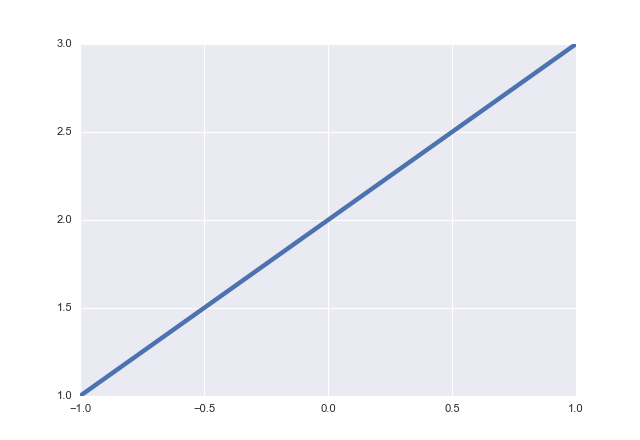

In [6]:
utils.plotModel(x1,y_hat)

### Visualizing the Modeling Function

Before we move on, let's spend some time examining the kinds of relationships that the linear model can capture -- the possible functions that can relate $x$ to $y$.

The cell below will generate a plot of a linear model. If you run the cell below that, the model will become interactive. Two sliders will appear that will let you change the parameters of the model -- the weights on the linear term and the constant term. Play with these sliders a bit and take a look at the range of possible linear models (with parameters between -1 and 1).

<IPython.core.display.Javascript object>


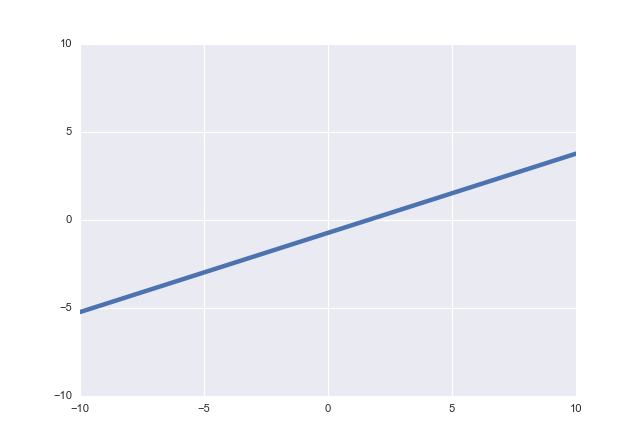

In [7]:
numDatapoints = 2500
inputValues = np.linspace(-10,10,numDatapoints)

parameters = utils.makeLinearParameters()

LM = utils.LinearModel(inputValues,parameters)

LM.plot()

In [8]:
LM.makeInteractive()

### Visualizing the Distribution of $y$

The above visualization lets us see the possible values of $\hat{y}$, the prediction of the model. But when we look at data, even data generated from a model, we don't get to see the true values of $\hat{y}$ directly, we only see $y$. 

The code below will make a linear model, then generate some random data from that model and plot it using seaborn's `jointplot`. 

#### Q Briefly, how do you generate data values according to a linear model? Assume the inputs are given to you.

The spread of the noise is set by the variable `noise_level`.

Running the code more than once will generate different linear models each time. Run the cell enough times that you get a sense of the diversity of models.

In [9]:
noise_level = 0.2
linearModelDataFrame = utils.randomLinearModel(noise_level,xMode='linspace')

<IPython.core.display.Javascript object>


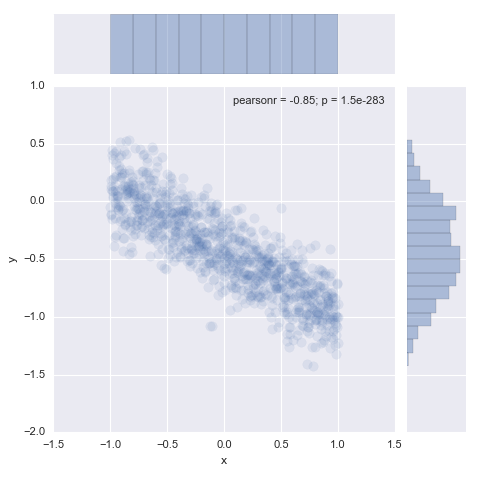

In [10]:
sns.jointplot(x='x',y='y',
              data=linearModelDataFrame,
              kind="scatter",
              joint_kws={"alpha":0.1,"s":72},);

#### Q If we were to draw the model predictions in as well, where would the line go?

Changing the argument `xMode` from `linspace` to `gauss` will change the distribution of x values that the model sees. 

In `linspace` mode, evenly-spaced x values are fed into the model and the resulting y values are plotted. In `gauss` mode, the x-values are also sampled from a Gaussian distribution.

#### Q Between the two modes, which distribution of values looks more like a "real" data distribution?

Say you perform an experiment where you take a linear system (a system described by a linear model) and examine its output behavior as you provide it evenly-spaced inputs from a minimum value to a maximum value.

#### Q Which distribution of values would you see?

## Linearized Models

### Specifying Linearized Models

Linear models won't always describe our data well. Linearized models are one popular alternative to linear models that retains most of the good features of linear models (easy to fit and write down, amenable to fast matrix multiplication) while avoiding the difficulties that plague truly non-linear models.

In a linearized model, we use the exact same trick that we used in order to be able to change the $y$-intercept of our linear model. We *transform* our data using a non-linear transformation and then treat the transformed data as just another dimension of our data. Another way to say this is that we add it to our matrix of `X` values as another regressor.

Numpy functions are super useful for implementing linearized models. This is because applying a numpy function like `np.square` or `np.cos` to a numpy array returns an array containing that function applied to each element of the original array. For example, when `x` is an array, `np.cos(x)` returns the same thing as:
```
y = np.zeros(len(x))
for idx in enumerate(x):
    y[idx] = math.cos(x[idx])
```
with a lot less typing!

Below, use `np.square` to add a regressor equal to $x^2$ to the `X` matrix, compute the predicted values `y_hat` using the provided weights `w`, and plot `y_hat` as a function of `x` using `plotModel`.

In [11]:
minimumInput = -1
maximumInput = 1
N = 10

x1 = np.linspace(minimumInput,maximumInput,N)
x0 = np.ones(N)
x2 = np.square(x1)

X = np.vstack([x2,x1,x0])
X.shape

(3, 10)

In [12]:
w = np.asarray([[1],[0],[2]])
w.shape

(3, 1)

In [13]:
w_transpose = w.T

y_hat = np.dot(w_transpose,X)
y_hat

array([[ 3.        ,  2.60493827,  2.30864198,  2.11111111,  2.01234568,
         2.01234568,  2.11111111,  2.30864198,  2.60493827,  3.        ]])

<IPython.core.display.Javascript object>


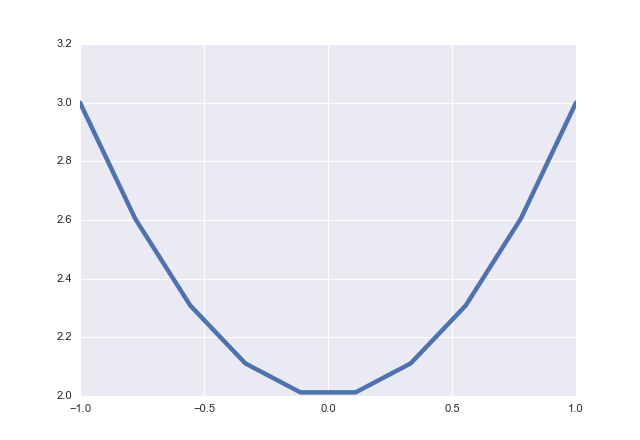

In [14]:
utils.plotModel(x1,y_hat)

Using the cell below, plot `y_hat` as a function of `x2`.

<IPython.core.display.Javascript object>


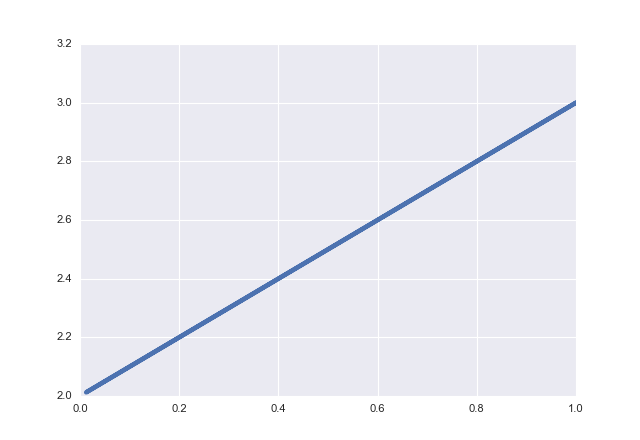

In [15]:
utils.plotModel(x2,y_hat)

#### Q What has changed? Why is this important?

### Visualizing the Modeling Function

The cell below will provide an interactive tool for examining possible modeling functions for a linearized model, just as was done above for a linear model.

To create a linearized model, you need to pick a list of transforms and then set up the parameters of your model. These become the variables `transforms` and `parameters` that are used by `utils.LinearizedModel` at the end of the cell. The cell contains code for either a polynomial model (provided for your convenience) or a model that uses arbitrary transforms. You should comment out the lines that you aren't using.

To make a list of transforms, you simply create a list of the functions you want to apply to x. For the quadratic (squared) model above, this would look like 

```
transforms = [np.square]
```

You can either provide the list yourself, e.g. `[np.sin, np.exp]` and so on, or you can use the `makePolynomialTransforms` function to automatically make the list of transforms for a polynomial model. You just need to tell it the maximum degree (`maxDegree`) that you'd like to include. For the quadratic model above, this would look like

```
maxDegree = 2
transforms = utils.makePolynomialTransforms(maxDegree)
```

You'll also need to provide a set of starting parameters to the model. If you're making your own list of `transforms`, simply provide that list to `makeLinearizedParameters`. If you used `makePolynomialTransforms`, then use `makePolynomialParameters` with the same value for `maxDegree`.

When you've got things set up as you'd like, run the next cell to plot the model, and the cell underneath to generate a panel of interactive sliders for adjusting the parameters of the model.

In [16]:
## Arbitrary Transforms
transforms = [np.sin, np.exp]
parameters = utils.makeLinearizedParameters(transforms)

## Polynomial Transforms 
maxDegree = 3
transforms = utils.makePolynomialTransforms(maxDegree)
parameters = utils.makePolynomialParameters(maxDegree,rnge=0.5)
# parameters = utils.makeSineParameters(maxDegree) #uncomment me later!

numDatapoints = 2500
inputValues = np.linspace(-10,10,numDatapoints)
M = utils.LinearizedModel(transforms,inputValues,parameters)

<IPython.core.display.Javascript object>


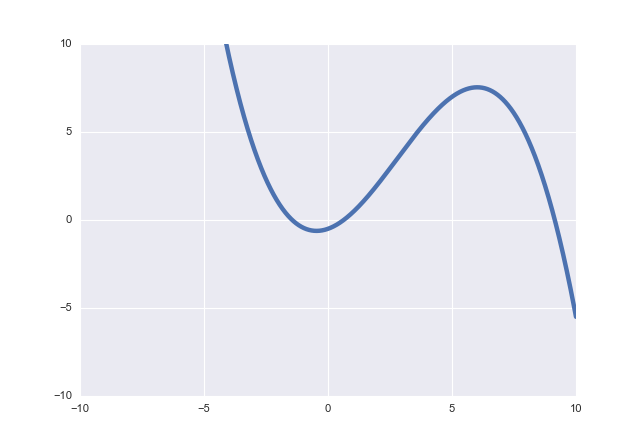

In [17]:
M.plot()

In [18]:
M.makeInteractive()

#### Q How are these models different from the linear models above?

A polynomial model can mimic a linear model by setting all the weights for the higher-degree regressors to 0.

#### Q Why don't we just always use polynomial models instead of linear models?

Just playing around by hand, the power and flexibility of polynomial models of data may not be apparent -- the models you get out just tend to look "like polynomials" -- a wiggle or two, then quickly growing to infinity or negative infinity. This is somewhat misleading, since a sufficiently high degree polynomial model can match any dataset.

As an example of just how powerful high-degree polynomials can be, combine `makeSineParameters` with `makePolynomialTransforms`. They both take a `maxDegree` argument. Start this value off at 7, and then increase it to 11, 17, and 25. Notice how the modeling function gets closer and closer something we don't usually think of as a polynomial -- the sine function! For technical reasons, you'll want to avoid running the `makeInteractive` command on this model.

### Visualizing the Distribution of $y$

Again, the section above allowed us to visualize $\hat{y}$, which we don't get to observe. We'd like to also be able to see what the actual data we'd get might look like. 

The code below will create a linearized polynomial model of a given `maxDegree`, feed in $x$ values as input, and then plot the resulting $x,y$ pairs. Once more, run the cell multiple times to get a sense of the diversity of models.

In [19]:
maxDegree = 11

noise_level = 0.5

linearizedModelDataFrame = utils.randomLinearizedModel(noise_level,maxDegree,
                                               xRange=[-1,1],
                                               xMode='linspace',N=1000)

<IPython.core.display.Javascript object>


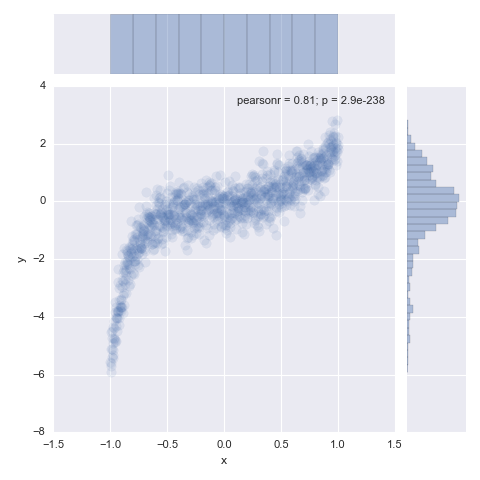

In [20]:
sns.jointplot(data=linearizedModelDataFrame,
              x='x',y='y',
              kind="scatter",joint_kws={"alpha":0.1,"s":72});

As part of `jointplot`, seaborn runs a linear regression and provides the correlation, $r$, and its $p$-value.

#### Q What does it mean for $r$ to be far away from 0?

The correlation is closely related to linear modeling.

#### Q The models plotted above are not linear models.  Why are we finding strong and significant correlations?

Say we took the values of one of our regressors, say $x^2$, and correlated those values with $y$.

#### Q How could we interpret this correlation?

## Parametric Nonlinear Models

### Specifying Parametric Nonlinear Models

A parametric nonlinear model looks like

$$
y = f(\theta,x)+\epsilon
$$

where $f$ is any function of $x$ and $\theta$ that changes nonlinearly when $\theta$ changes. For example, we could have:

$$
f(\theta,x) = \mathrm{sin}(\theta x) \\ f(\theta,x) = \mathrm{e}^{\theta x} \\ f(\theta,x) = x^\theta
$$

or more exotic functions, like this neurally-inspired function, the *rectified linear function*:

$$
f = \begin{cases} x-\theta, & \text{if } x > \theta \\
                  0, & \text{otherwise}
    \end{cases}
$$

or really just about any function we can dream up! 

As a technical note for the curious: why not *any* function? We usually want our function to be *differentiable almost everywhere*. That is, we want to be able to find its derivative, and we want to be able to do that *almost everywhere* (so something like the rectified linear function doesn't cause us trouble, since it has a derivative everywhere except at 0).

In the cell below, pick whatever non-linear function you want and plot `y_hat` as a function of the input `x` for a fixed value of `theta`.

In [21]:
f = lambda theta,x: np.where(np.abs(x)>np.abs(theta),x,0)
#f = lambda theta,x: np.where(x>theta,x-theta,0)

x = np.linspace(-1,1,numDatapoints)

theta = np.random.rand()

y_hat = f(theta,x)

<IPython.core.display.Javascript object>


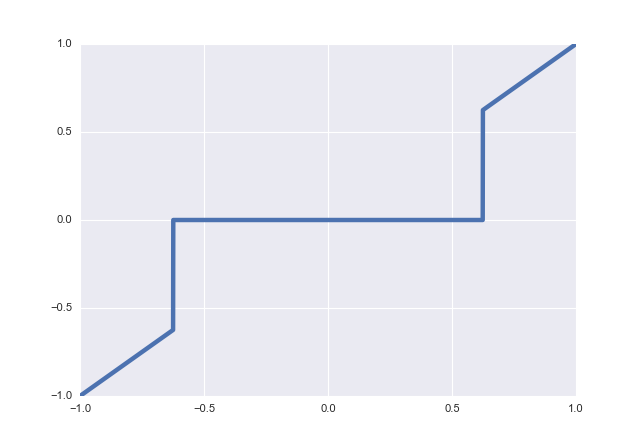

In [22]:
utils.plotModel(x,y_hat)

### Visualizing the Modeling Function

The cell below will let you visualize how the modeling function changes as the parameters change for a variety of nonlinear parametric models.

Three are provided for you:  and 

- a power model where $x$ is raised to the power given by the parameter $\theta$. `maxPower` specifies an upper bound for the slider that changes the parameter value.

- a trigonometric model where $x$ is first multiplied by $\theta$ and then fed to the trigonometric function you provide (`np.sin`, `np.cos`, `np.arctan`, etc.).

- a rectified linear model with a threshold given by $\theta$.

The fourth is more free-form. Given a function $g$ that takes in a value $x$, it makes a new function that looks like $f(\theta, x) = g(\theta * x)$. Examples you've seen already include $\mathrm{sin}(\theta*x)$ and $\mathrm{e}^{\theta * x}$, where $g$ is $sin$ and $\mathrm{exp}$. These are called *linear-nonlinear* models. You can make your own if you'd like! You can change the minimum and maximum values for the inputs $x$ and parameter $\theta$ by changing the values in the lists passed to `setupLN`.

In [23]:
# maxPower = 3
# inputValues,parameters,transform = utils.setupPower(maxPower)

#inputValues,parameters,transform = utils.setupTrig(np.arctan)

inputValues,parameters,transform = utils.setupRectLin()

# transform = np.exp
# inputValues, parameters, transform = utils.setupLN(transform,
#                                                    [-10,10],
#                                                    thetaRange=[-1,1])

NLPM = utils.NonlinearModel(inputValues,parameters,transform)

<IPython.core.display.Javascript object>


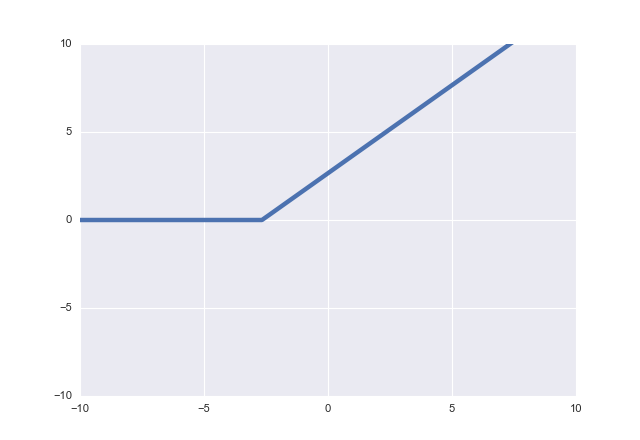

In [24]:
NLPM.plot()

In [25]:
NLPM.makeInteractive()

#### Q How is the "power model" here different from a linearized polynomial model?

#### Q What differences do you see between a nonlinear model that uses $\mathrm{sin}(\theta \cdot x)$ and a linearized model that uses $\theta \cdot \mathrm{sin}(x)$?

### Visualizing the distribution of $y$

As before, plotting the outputs for a variety of parameter settings gives us a sense of the relationships that can be captured by a class of models, but it doesn't give us a good sense of what kinds of data we might see if our model is correct.

The cell below will generate data according to a given parametric nonlinear model with randomly chosen parameters. Run the cell several times to see multiple examples.

In [26]:
numDatapoints = 1000
noise_level = 0.5

# Rectified Linear Model with threshold theta
f = utils.makeRectLinTransform()
thetaRange = [-1,1]
xRange = [-2,2]

# x^theta Model
# f = utils.makePowerTransform()
# thetaRange = [0,5]
# xRange = [0,2]

# f(theta*x) Model
# f = utils.makeLNTransform(np.sin)
# thetaRange = [0.5,5]
# xRange = [-2,2]

nonlinearModelDataFrame = utils.randomNonlinearModel(noise_level,f,
                                             N=numDatapoints,
                                             xMode='uniform',xRange=xRange,
                                            thetaRange=thetaRange)

<IPython.core.display.Javascript object>


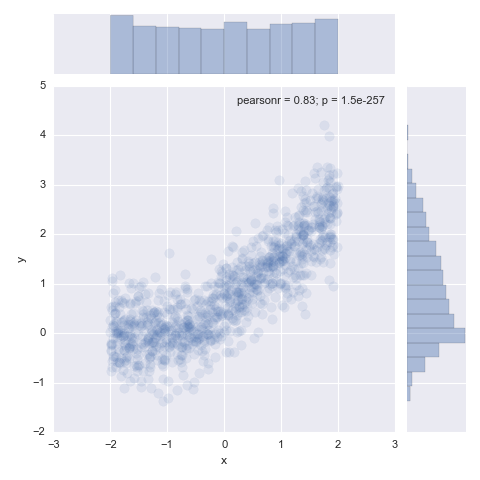

In [27]:
sns.jointplot(data=nonlinearModelDataFrame,
              x='x',y='y',
              kind="scatter",joint_kws={"alpha":0.1,"s":72});

## Non-Parametric Models

Our models so far have been *parametric* models, since they included a small number of parameters, vectors of $w$ or $\theta$. For the models we've considered so far, this has severely limited the kinds of relationships our functions have been able to capture. The technical way of saying this is that it has limited the *expressivity* of our models.

One way to fix this is by attacking it directly: improving the expressivity of the nonlinear functions in our parametric models. We used simple functions, like the trigonometric functions and exponential functions, but these turn out to be bad choices for expressivity. By trial and error, the field of machine learning has stumbled upon *neural networks* as a good choice. In a neural network, multiple linear-nonlinear functions are chained together, one after the other. For reasons that are still under research, this is a fabulous way to get tremendous expressivity out of small numbers of parameters.

We won't spend a ton of time on neural networks in this class, so if you'd like to see those models in action, check out Google's [Neural Network Playground](http://playground.tensorflow.org/).

The other way to fix this is by using the dataset as the parameters of the model. That is, we try to come up with a clever function $f(x,D)$, where $D$ is the entire dataset, that does a good job predicting $y$. Because the model depends directly on the data, and not on any parameters, we call these models *non-parametric* models. Non-parametric models are able to model any relationship between variables, but they're usually computationally expensive to fit and to get predictions out of, and they have worse performance on data that is actually generated by a parametric model.

This should remind you of the non-parametric statistical methods we've discussed, like the bootstrap. In the bootstrap, the model of our data was the data itself, through its empirical CDF. The empirical CDF, unlike the mean or the variance, gets harder to describe as we get more data: to write down an empirical CDF, you need to know the location of each "step" in the function -- of each data point -- while to know the mean or variance you only need one number. Bootstrap models were also more computationally expensive and performed worse on models that came from parametric distributions.

### Defining "Non-Parametric"

Some folks, like Kendrick Kay, like to lump neural networks in with non-parametric models. For them, the key property of non-parametric models is that they solve our expressivity problem and, relatedly, don't make strong assumptions about the kinds of relationships that might be in the data. Non-parametric models and neural networks are similar in this regard.

Though I understand where this perspective is coming from, I think it's somewhat confusing, especially since polynomial models can also be very expressive, especially when they have as many degrees as neural networks have parameters (in the tens, if not hundreds, of thousands!). It's also absolutely the case that neural networks have parameters, so folks like Kendrick find themselves in the awkward position of having a "non-parametric" model that has parameters!

### Example Non-Parametric Model: Local Regression

Because of how expressive non-parametric models are, we can't make the visualizations that we made above quite so easily -- we'd need a slider for the location of each data point to make them interactive, for example.

Instead, we'll take a look at the results of fitting a particular non-parametric model, local regression, to data that comes from the models we've considered so far.

In local regression, we fit a different model at each x-value (not just at each datapoint), and then combine them together. The most common model is called *LOWESS*, for **LO**cally **WE**ighted **S**catterplot **S**moothing. It's a local regression model and can be thought of as a smoother version of nearest-neighbor regression, hence the first, third, and fourth words in its name. At each possible value for $x$, we fit a (possibly linear) regression model to the nearest datapoints, with more emphasis on the datapoints that have the the most similar $x$ values. Mathematically, the emphasis shows up as a *weight* that increases or decreases the contribution of data points to each model, explaining the second term in the method's name.

LOWESS is computationally expensive and difficult to implement, but luckily, seaborn will runa farily efficient LOWESS instead of linear regression if you ask. The function for simultaneously fitting and plotting regression models in seaborn is `lmplot`. If you pass the argument `lowess=True` to `lmplot`, seaborn will use LOWESS to fit the regression.

<IPython.core.display.Javascript object>


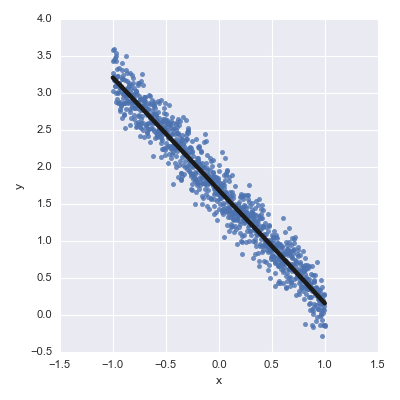

In [28]:
noise_level = 0.2
linearModelDataFrame = utils.randomLinearModel(noise_level,xMode='linspace')

sns.lmplot(data=linearModelDataFrame,
           x='x',y='y',
            lowess=True,
           line_kws={'color':'k','linewidth':4});

<IPython.core.display.Javascript object>


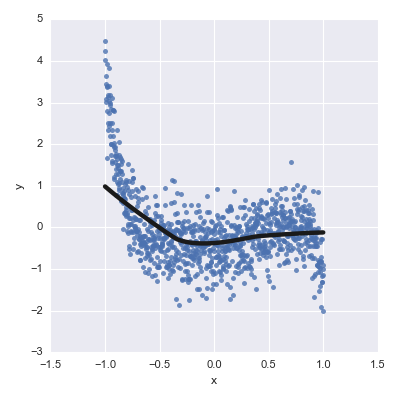

In [29]:
maxDegree = 11
noise_level = 0.5
linearizedModelDataFrame = utils.randomLinearizedModel(noise_level,maxDegree,
                                               xRange=[-1,1],
                                               xMode='linspace',N=1000)

sns.lmplot(data=linearizedModelDataFrame,
           x='x',y='y',
            lowess=True,
           line_kws={'color':'k','linewidth':4});

<IPython.core.display.Javascript object>


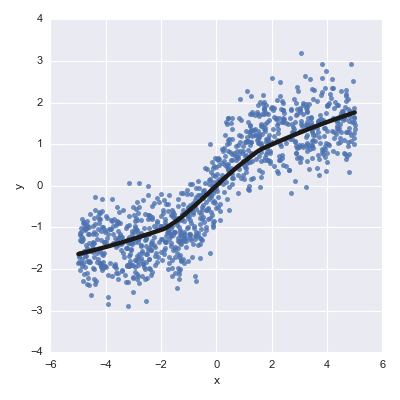

In [31]:
# f(theta*x) Model
f = utils.makeLNTransform(np.arctan)
thetaRange = [0,2.5]
xRange = [-5,5]

## for question below
# f = utils.makeLNTransform(np.sin)
# thetaRange = [0.25,2.5]
# xRange = [-2,2]

nonlinearModelDataFrame = utils.randomNonlinearModel(noise_level,f,
                                             N=numDatapoints,
                                             xMode='uniform',xRange=xRange,
                                            thetaRange=thetaRange)
sns.lmplot(data=nonlinearModelDataFrame,
           x='x',y='y',
            lowess=True,
           line_kws={'color':'k','linewidth':4});

Using `np.sin` as the argument to `makeLNTransform`, run the above cell multiple times.

#### Q Do you notice anything "off" about the fits that LOWESS finds?